In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from  torch.distributions import normal , MultivariateNormal
import GPE_ensemble as GPE

dtype = torch.float
device = torch.device("cpu")

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The code in this notebook gives a simple example of model calibration using the metropolis hastings algorith, the emcee python package and gaussian process emulators

# Observational model: $y=f(x)+\epsilon$  

For some data, $x$, and observations, $y$, we believe the following model applies:

$y=bx+\epsilon$

Then we can write the conditional distribution

$y|x \sim N(bx,\sigma_e^2)$

If our prior over $x$ is also normal, i.e.

$x \sim N(\mu_0,\sigma_0^2)$

Then the true posterior is:

$x|y \sim N(\mu_p,\sigma_p^2)$

where

$\mu_p = \frac{\sigma_0^2by+\sigma^2\mu_0}{\sigma_0^2b^2+\sigma^2}$

and

$\sigma_p^2 = \frac{2\sigma_0^2\sigma^2}{\sigma_0^2b^2+\sigma^2}$

We will use this true posterior to compare to our MCMC results

In [2]:
rl = -10 #lower observational bound
ru=20 #upper observational bound

b=0.5 #b in y=bx+e

def lin(x): #define linear function y=bx
    y = b*x
    return y

tp = 500 # number of test points

x_test = torch.linspace(ru,rl,tp) #test points over full range


# Using our observational model we want to calibrate to y=3

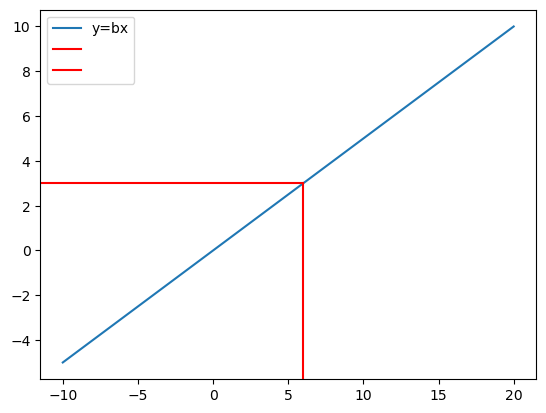

In [3]:
plt.plot(x_test,lin(x_test).detach().numpy())
plt.axhline(y=3, color='r', linestyle='-',xmax=0.53)
plt.axvline(x=6, color='r', linestyle='-',ymax=0.53)
plt.legend(("y=bx",'',''))

In [4]:
dist_prior = normal.Normal(loc=0, scale=1) #Define prior over x
val_prior = torch.exp(dist_prior.log_prob(x_test)) # Evaluate the prior at the test set

# Calibrating with Metropolis hastings

## The metropolis hastings acceptance probability and algorithm

In [5]:
def acceptance(y,x,x_prime,sigma2): # Log acceptance probabilty (for stability)
    ratio = (-0.5*x_prime**2-0.5*(1/sigma2)*(b*x_prime-y)**2)-(-0.5*x**2-0.5*(1/sigma2)*(b*x-y)**2)
    alpha = np.min((0,ratio))
    return alpha

In [6]:
def metrop(y_cal,x0,sigma2_mc,sigma2_e,iters):
    chain = np.zeros(iters+1) #Initialise markov chain
    chain[0]=x0 #set x0 as first element
    for i in range(iters):
        x = chain[i] #define x
        x_p = np.random.normal(chain[i],sigma2_mc) #select candidate value x'
        alpha = acceptance(y,x,x_p,sigma2_e) #calculate alpha
        u=np.random.uniform() #generate random uniform variable
        if np.log(u)<alpha: 
            chain[i+1]=x_p #accept candidate value
        else:
            chain[i+1]=x #reject candidate value
    return chain



In [7]:
y=3 # Calibration value for y
x0 = 0 # Chain starting point
sigma2_mc =1 # MCMC proposal variance
sigma2_e=0.1 # Observation error variance
iters=10000 # Number of MCMC iterations

In [8]:
posterior_mean = (1/((b**2)+sigma2_e))*b*y # True posterior mean
posterior_cov = sigma2_e/(b**2 + sigma2_e) #True posterior covariance
    
dist_posterior = normal.Normal(loc=posterior_mean, scale=np.sqrt(posterior_cov)) #Define posterior distribution
posterior_True = torch.exp(dist_posterior.log_prob(x_test)) # Evaluate posterior over test set

In [9]:
X = metrop(y,x0,sigma2_mc,sigma2_e,iters)

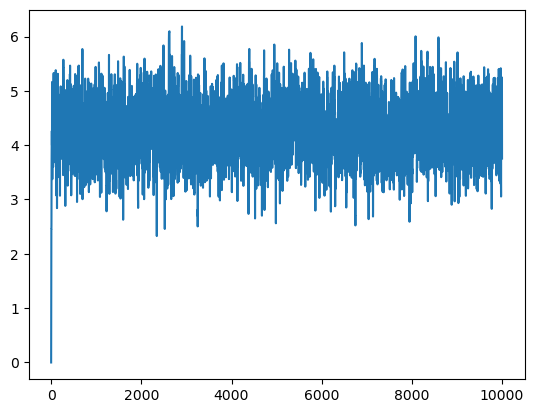

In [10]:
plt.plot(X)

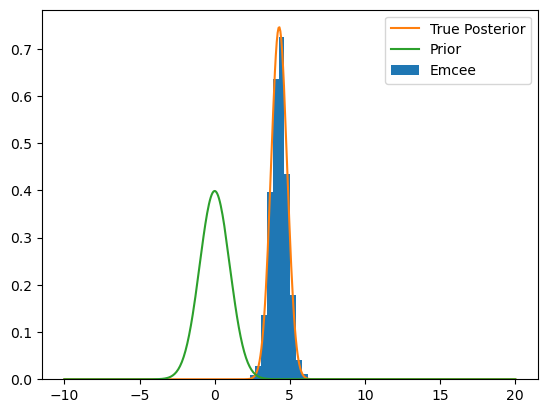

In [11]:
plt.hist(X[2000::],density=True)
plt.plot(x_test.detach().numpy(),posterior_True.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(['True Posterior','Prior','Emcee'])

# Calibrating with the emcee package

In [12]:
import emcee
ndim = 1 #Dimension of x
nwalkers = 2 # Number of emcee walkers (package recommends at least 2 x ndim)
p0 = np.random.normal(0,1,2) #Initial positions for walkers

## Define log-prior, log-likelihood and log-prob for emcee

In [13]:
def log_prior(theta): #N(0,1) log pdf as the prior
    lp = -(0.5)*theta**2
    return lp

def log_likelihood(y,theta,sigma2_e): #Log likelihood up to proportionality
    ll = -(0.5/(sigma2_e))*(b*theta-y)**2
    return ll
    
def log_prob(theta,y,sigma2_e): # Log probability (prior x likelihood)
    
    lp = log_prior(theta)
    ll =log_likelihood( y,theta,sigma2_e)
    return lp + ll

## Set up and run emcee sampler

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[y,sigma2_e]) #Set up an emcee sampler

In [15]:
sampler.run_mcmc(p0[:,None], 10000) # Run sampler

State([[4.12793702]
 [4.14249742]], log_prob=[-12.90070677 -12.89303723], blobs=[], random_state=('MT19937', array([ 753744889, 2692395912,  231147514,  411458243,   73332981,
       3169917197,  874170413, 2507622219, 1972122957,  990674518,
       2601672622,  932357767, 1941727945, 3880112438,    5401652,
       1126093054, 1339952779, 2226801410,  981544972, 3147494492,
       4060273500, 3522815388,  228701912, 2559337894,  322603752,
       2752414178, 1699261464,  450837497, 3938021039, 2813770832,
       1392787788, 2844548419, 2960202145, 2505166549, 2805065607,
       3550317363, 3941923397, 2646178224,  873267911, 3208754068,
       1614174699,  452346657, 3178056324, 2848693245, 2979518316,
       3277889360,  356897524, 1718029666, 2193044934,  981377971,
       4156003722, 1477850164,  431270678, 4012906107, 2227647062,
       4261954075, 3328328461,  166609883, 1407880693,   91793381,
        418370692,  870936912,  914351060, 1665799965,   60277043,
       2693367505, 2

In [16]:
# Flatten walkers, discard first 2000 points as burn in, thin the samples by 10

flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True) 
print(flat_samples.shape)

(1600, 1)


## Plot a histogram of the MCMC posterior, the true posterior and the prior

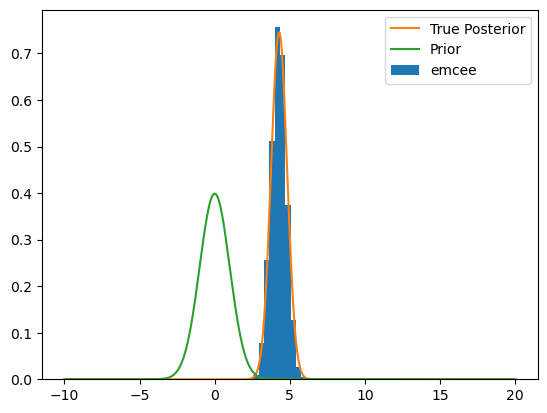

In [17]:
plt.hist(flat_samples,density=True)

plt.plot(x_test.detach().numpy(),posterior_True.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(['True Posterior','Prior','emcee'])

## Plot the trace plot

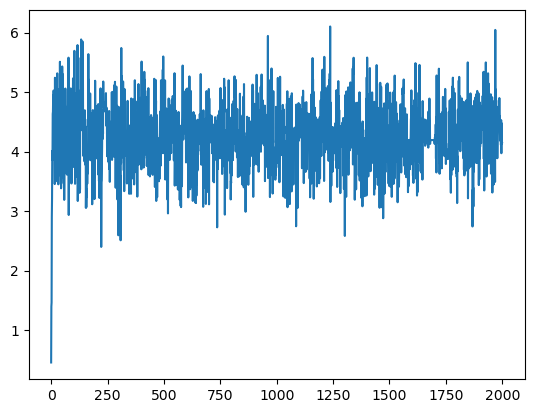

In [18]:
plt.plot(sampler.get_chain(thin=10,flat=True))

# MCMC with an emulator in place of $f(x)$

(-6.0, 10.0)

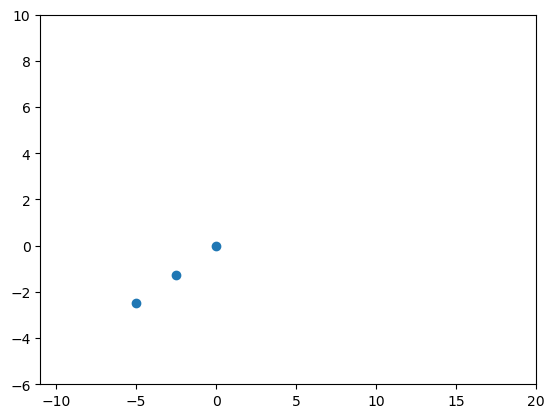

In [19]:
p=3 #Number of training points

x_train=torch.linspace(-5,0,p) #Training point locations

y_train = lin(x_train) #Observations (function evaluated at training points)

plt.plot(x_train.detach().numpy(),y_train.detach().numpy(),'o')
plt.xlim(-11,20)
plt.ylim(-6,10)

In [20]:
emulator=GPE.ensemble(x_train[:,None],y_train[:,None]) #Train emulator using GPE ensemble

0


## Plot emulator against true $f(x)$

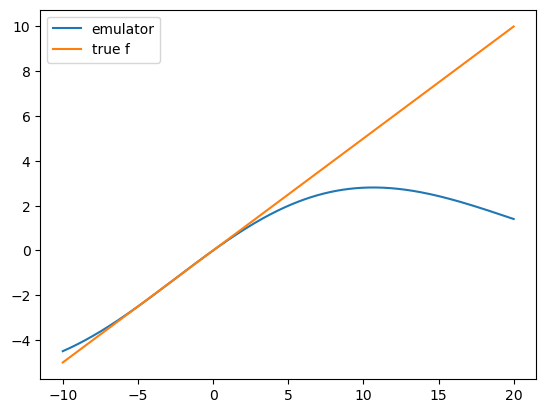

In [21]:
plt.plot(x_test.detach().numpy(),emulator.predict(x_test).detach().numpy())
plt.plot(x_test,lin(x_test).detach().numpy())
plt.legend(('emulator','true f'))

## Rewrite log-likelihood and log-prob to account for emulator

In [22]:
def log_likelihood_emulator(y,theta,sigma2_e,emulator):
    y=torch.tensor([y])[:,None]
    theta=torch.tensor(theta)[:,None]
    sigma2_e=torch.tensor([sigma2_e])[:,None]
    ll = emulator.ensemble_log_likelihood_obs_error(theta,y,sigma2_e).detach().numpy()
    return ll
    
def log_prob_emulator(theta,y,sigma2_e,emulator):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll =log_likelihood_emulator(y,theta,sigma2_e,emulator)
    return lp + ll

## Plot the log-likelihood over the domain

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_96667/1656969703.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta=torch.tensor(theta)[:,None]


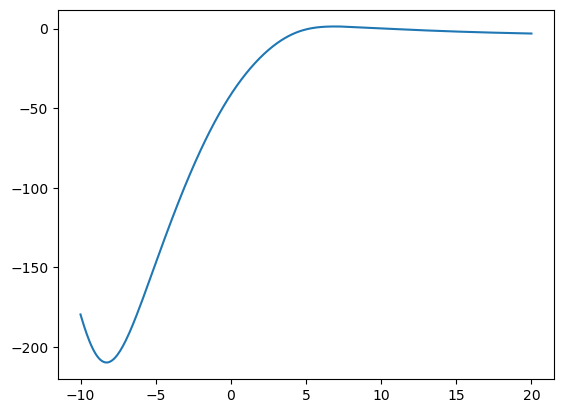

In [23]:
plt.plot(x_test,log_likelihood_emulator(y,x_test,sigma2_e,emulator).T)

## Set up and run emcee sampler

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_emulator, args=[y,sigma2_e,emulator])

In [25]:
sampler.run_mcmc(p0[:,None], 10000)

State([[4.06989834]
 [4.08141818]], log_prob=[-11.86604399 -11.86284833], blobs=[], random_state=('MT19937', array([ 753744889, 2692395912,  231147514,  411458243,   73332981,
       3169917197,  874170413, 2507622219, 1972122957,  990674518,
       2601672622,  932357767, 1941727945, 3880112438,    5401652,
       1126093054, 1339952779, 2226801410,  981544972, 3147494492,
       4060273500, 3522815388,  228701912, 2559337894,  322603752,
       2752414178, 1699261464,  450837497, 3938021039, 2813770832,
       1392787788, 2844548419, 2960202145, 2505166549, 2805065607,
       3550317363, 3941923397, 2646178224,  873267911, 3208754068,
       1614174699,  452346657, 3178056324, 2848693245, 2979518316,
       3277889360,  356897524, 1718029666, 2193044934,  981377971,
       4156003722, 1477850164,  431270678, 4012906107, 2227647062,
       4261954075, 3328328461,  166609883, 1407880693,   91793381,
        418370692,  870936912,  914351060, 1665799965,   60277043,
       2693367505, 2

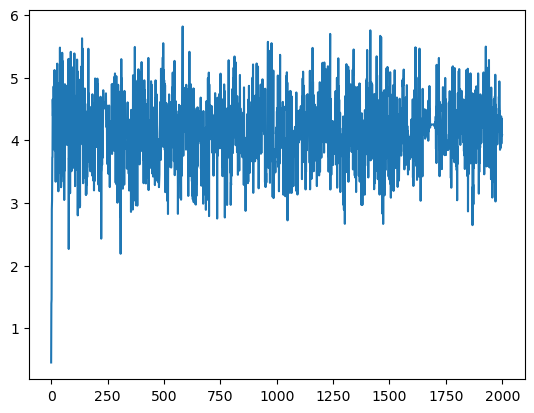

In [26]:
plt.plot(sampler.get_chain(thin=10,flat=True))

## Plot True posterior against Emulator MCMC, True MCMC and prior

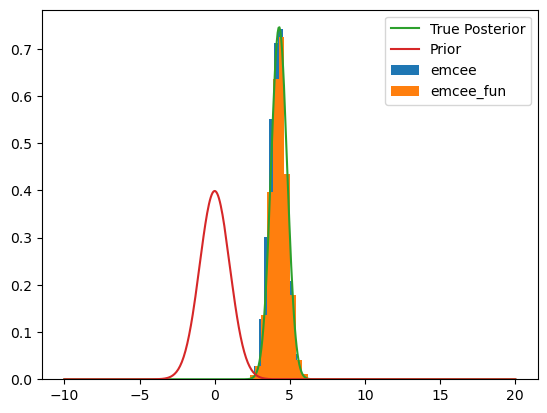

In [27]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
plt.hist(flat_samples,density=True)
plt.hist(X[2000::],density=True)
plt.plot(x_test.detach().numpy(),posterior_True.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(['True Posterior','Prior','emcee','emcee_fun'])